In [1]:
import json
from math import floor
import matplotlib.pyplot as plt
import requests
import numpy as np
from scipy.interpolate import interpn
import pandas as pd

ANGLE = 0.000_675  # Approx 75m latitude

In [2]:
# Coordinate box around Thruxton
with open("coords.json", "r") as file:
    coords = json.load(file)

# Load path of rider around Thruxton
path = pd.read_csv("path.csv", index_col=False)

In [3]:
def aspect(lat):
    """Scale factor for converting distance at lat -> lon."""
    return 1 / np.cos(np.radians(lat))


def resize_bbox(coords, angle=ANGLE):
    """Create nxm rectange, divides evenly into squares.

    Output box always starts in top left corner and expands in multiples of
    `angle` until it reaches bottom right corner and does not exceed that.

    Args:
        coords (dict): Coordinates, keys N, S, E, W
        angle (float): The angle of latitude to break into, default 0.000675
    Returns:
        bbox (list[float]): WSGI84 coordinates, [South, West, East, North]
        N_lat (int): number of rows
        N_lon (int): number of cols
    """

    delta_lat = abs(coords["N"] - coords["S"])
    delta_lon = abs(coords["E"] - coords["W"])

    # meters / degree lon decreases with latitude
    h_angle = aspect(coords["N"] - delta_lat / 2) * angle

    N_lat = floor(delta_lat / angle)
    N_lon = floor(delta_lon / h_angle)

    # Top Left corner
    tl = (coords["N"], coords["W"])
    # Bottom Right corner
    br = (tl[0] - N_lat * angle, tl[1] + N_lon * h_angle)
    # WSGI84 bounding box
    # south latitude, west longitude, north latitude, east longitude
    bbox = [br[0], tl[1], tl[0], br[1]]
    return bbox, N_lat, N_lon


def get_elevations(key, bbox, rows, cols):
    """Calls the Bing Maps API -> list of coordinates of grid inside bbox.

    Args:
        key (str): Bing Maps API key
        bbox (list[float]): WSGI84 bounding box [S W N E]
        rows (int): Number of latitude boxes
        cols (int): Number of longitude boxes

    Raises:
        ValueError: If rows*cols is greater than max allowed by Bing API (1024)
        Exception: Nonstandard response, e.g. HTTP/400

    Returns:
        list[int]: Heights per coordinate as a flattened array using C style (row-major)
    """
    if rows * cols > 1024:
        raise ValueError("Number of points cannot be larger than 1024")
    URL = f"http://dev.virtualearth.net/REST/v1/Elevation/Bounds?bounds={','.join([str(i) for i in bbox])}&rows={rows}&cols={cols}&key={key}"

    req = requests.get(URL)
    res = req.json()
    if res["statusCode"] != 200:
        raise Exception(f"error for {URL}     Bad request: {res['statusDescription']}")

    return res["resourceSets"][0]["resources"][0]["elevations"]

In [4]:
resize = resize_bbox(coords=coords, angle=ANGLE)


def elevations(fpath: str | None = None):
    if not fpath:
        # Bing maps API key
        try:
            with open(".bing_key", "r") as file:
                BING_KEY = file.read().strip()
        except FileNotFoundError as e:
            raise FileNotFoundError(
                "Make a file in this folder called '.bing_key' which "
                "contains a Bing maps API key, from "
                "https://learn.microsoft.com/en-us/bingmaps/getting-started/bing-maps-dev-center-help/getting-a-bing-maps-key"
            ) from e

        res = get_elevations(BING_KEY, *resize)
        df = pd.DataFrame(dict(elevation=res))
        df.to_csv("elevation.csv", index=False)
        return res
    else:
        df = pd.read_csv(fpath, index_col=False)
        return df.elevation.astype(int).to_list()


# Change this to True to use the Bing API to get a new list of elevations
RESET_ELEVATIONS = False
if RESET_ELEVATIONS:
    res = elevations('elevation.csv')
else:
    res = elevations()


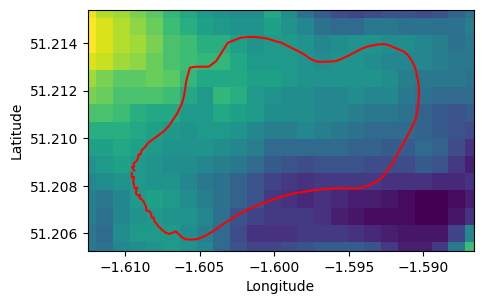

In [5]:
def get_grid(bbox, rows, cols):
    """Numpy x and y arrays from a bbox split into rows & cols."""
    y = np.linspace(bbox[0], bbox[2], rows)
    x = np.linspace(bbox[1], bbox[3], cols)
    return x, y


def plot_elevation(ax, bbox, rows, cols, data, alpha=1.0):
    """Formatted plot of elevation data.

    Args:
        ax (plt.Axes): axis plot on
        bbox (list[float]): WSGI84 bounding box [S W N E]
        rows (int): number of rows
        cols (int): number of cols
        data (list[int]): height data
        alpha (float, optional): Transparency of height colours. Defaults to 1.0.
    """
    x, y = get_grid(bbox, rows, cols)

    XX, YY = np.meshgrid(x, y)
    ZZ = np.reshape(data, (rows, cols))

    ax.pcolormesh(XX, YY, ZZ, alpha=alpha)
    ax.set_aspect(aspect(y[rows // 2]))
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim((x[0], x[-1]))
    ax.set_ylim(*(y[0], y[-1]))


bbox = resize[0]
# Aspect for figure size
aspect_ratio = abs((bbox[2] - bbox[0]) / (bbox[3] - bbox[1]))
fig, ax = plt.subplots(1, figsize=(8, 8 * aspect_ratio))

plot_elevation(ax, *resize, res)
grid = get_grid(*resize)



ax.plot(path.lon, path.lat, color="r")
plt.show()

Text(0, 0.5, 'Longitude')

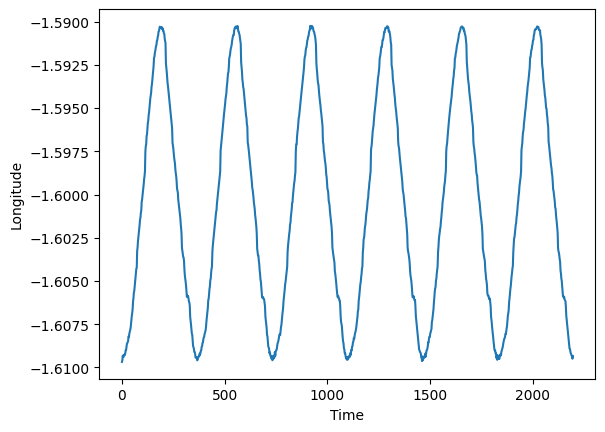

In [6]:
dt = 2  # seconds
path_np = np.stack([path.lon, path.lat], axis=0)

# 6 laps of the course
path_np = np.tile(path_np, (1, 6))
# Add random noise to simulate slightly different laps
jitter = path_np + np.random.normal(0, 0.00005, path_np.shape)
# Timestamp of each point along lap
t_jitter = np.arange(jitter.shape[1]) * dt

plt.plot(np.arange(0, jitter.shape[1]) * dt, jitter[0])
plt.xlabel("Time")
plt.ylabel("Longitude")

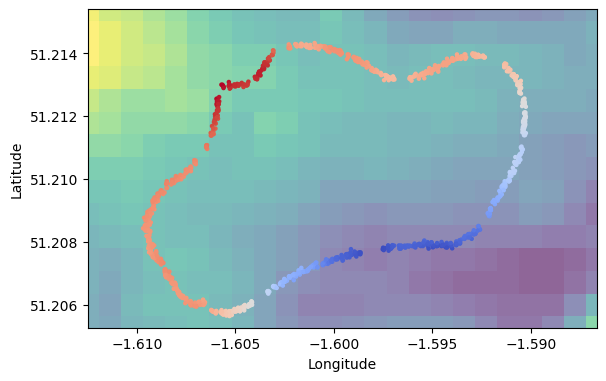

In [7]:
# Use Scipy's `interpn` N-Dimensional interpolator to approximate the elevation
heights = interpn(
    (grid),                                                     # (x, y) arrays of x and y coordinates
    np.c_[res].reshape(len(grid[0]), len(grid[1]), order="F"),  # [nx, ny] array of height values
                                                                #   converted to array and reshaped using
                                                                #   _Fortran_ style (column-major)
    jitter.T,                                                   # Sample the interpolated grid at the x,y 
                                                                #   coordinates of each timestamp of ride
    "cubic",                                                    # Use cubic (smooth, slow) interpolation
                                                                #   alternatives are linear (jagged, faster)
                                                                #   and quintic (smoooth, slower)
)

fig, ax = plt.subplots(1, figsize=(10, 10 * aspect_ratio))
plot_elevation(ax, *resize, res, alpha=0.6)
XX, YY = np.meshgrid(*grid)
ax.scatter(jitter[0], jitter[1], c=heights, s=5, cmap='coolwarm')
plt.tight_layout()
plt.show()

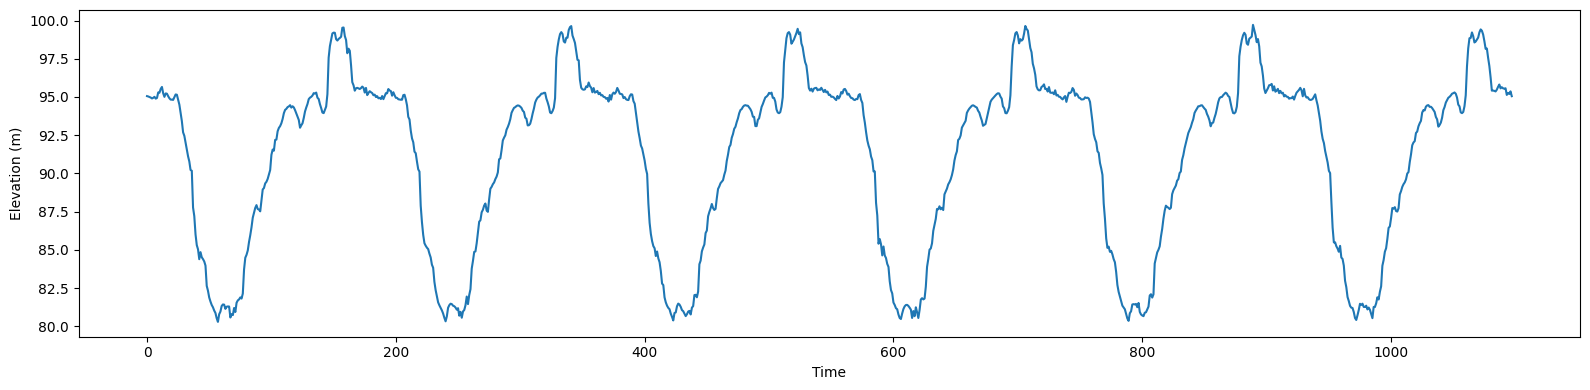

In [9]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(np.arange(*heights.shape), heights)
ax.set_ylabel("Elevation (m)")
ax.set_xlabel("Time")
plt.tight_layout()
plt.show()